In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(42)

In [2]:
# Parameters
nx = 300  # Number of spatial grid points
L = 5.0  # Length of the domain
dt = 0.01  # Time step
a = 1.0  # Advection speed
T = 5.0  # Total simulation time
nt = int(T / dt)  # Number of time steps
dx = L / (nx - 1)  # Spatial resolution

# Grid points
x = np.linspace(0, L, nx)
t = np.linspace(0, T, int(T/dt))

c = a * dt / dx # Courant Number
print(f"Courant Number: {c}")

# Initial condition: Gaussian pulse
def initial_condition(x):
    return np.exp(-((x - L / 4) / 0.1) ** 2)

Courant Number: 0.5980000000000001


In [3]:
# Define the neural network
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(2, 128)  # Input: (x, t)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 128)
        self.fc5 = nn.Linear(128, 128)
        self.fc6 = nn.Linear(128, 1)  # Output: u(x, t)

    def forward(self, x, t):
        inputs = torch.cat([x, t], dim=1)  # Concatenate x and t
        out = torch.sin(self.fc1(inputs))
        out = torch.sin(self.fc2(out))
        out = torch.sin(self.fc3(out))
        out = torch.sin(self.fc4(out))
        out = torch.sin(self.fc5(out))
        out = self.fc6(out)
        return out

# Initialize network and optimizer
model = NeuralNetwork()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define loss functions
def pde_loss(x, t, a):
    x.requires_grad_(True)
    t.requires_grad_(True)
    u = model(x, t)
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    return torch.mean((u_t + a * u_x) ** 2)

def ic_loss(x):
    # Detach x and convert to NumPy for initial_condition
    x_np = x.detach().numpy()
    u_true = torch.tensor(initial_condition(x_np), dtype=torch.float32).reshape(-1, 1)
    u_pred = model(x, torch.zeros_like(x))  # Evaluate at t = 0
    return torch.mean((u_pred - u_true) ** 2)

def boundary_loss(t):
    # Sample points at the boundaries (x = 0 and x = L)
    x_left = torch.zeros_like(t)  # x = 0
    x_right = torch.full_like(t, L)  # x = L

    # Evaluate the model at the boundaries
    u_left = model(x_left, t)
    u_right = model(x_right, t)

    # Compute the mean squared error of the difference
    return torch.mean((u_left - u_right) ** 2)

losses = []
# Training loop
for epoch in range(10000):
    optimizer.zero_grad()

    # Sample random collocation points
    num_samples = 100
    x_torch = torch.tensor(np.random.choice(x, num_samples, replace=True), dtype=torch.float32).reshape(-1, 1)
    t_torch = torch.tensor(np.random.choice(t, num_samples, replace=True), dtype=torch.float32).reshape(-1, 1)

    # Compute losses
    loss_pde = pde_loss(x_torch, t_torch, a)
    loss_ic = ic_loss(x_torch)
    loss_boundary = boundary_loss(t_torch)  # Add boundary loss
    loss = 2*loss_pde + loss_ic + loss_boundary  # Include boundary loss in total loss
    losses.append(loss.detach().numpy())

    # Backpropagation
    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}, PDE Loss: {loss_pde.item()}, IC Loss: {loss_ic.item()}, Boundary Loss: {loss_boundary.item()}")

Epoch 0, Loss: 0.029039505869150162, PDE Loss: 0.0007470471318811178, IC Loss: 0.025222210213541985, Boundary Loss: 0.002323200460523367
Epoch 1000, Loss: 0.003722636727616191, PDE Loss: 0.0011168934870511293, IC Loss: 0.0010963279055431485, Boundary Loss: 0.00039252187707461417
Epoch 2000, Loss: 0.0006016841507516801, PDE Loss: 0.00016731249343138188, IC Loss: 0.00010192173795076087, Boundary Loss: 0.0001651374186621979
Epoch 3000, Loss: 0.00019533738668542355, PDE Loss: 7.484722300432622e-05, IC Loss: 1.7378200936946087e-05, Boundary Loss: 2.8264732463867404e-05
Epoch 4000, Loss: 0.00023076881188899279, PDE Loss: 5.64512301934883e-05, IC Loss: 4.2824485717574134e-05, Boundary Loss: 7.504186214646325e-05
Epoch 5000, Loss: 1.557152245368343e-05, PDE Loss: 3.7685304050683044e-06, IC Loss: 6.3648212744737975e-06, Boundary Loss: 1.6696410511940485e-06
Epoch 6000, Loss: 0.00028162726084701717, PDE Loss: 2.757115726126358e-05, IC Loss: 0.00017685035709291697, Boundary Loss: 4.96346001455094

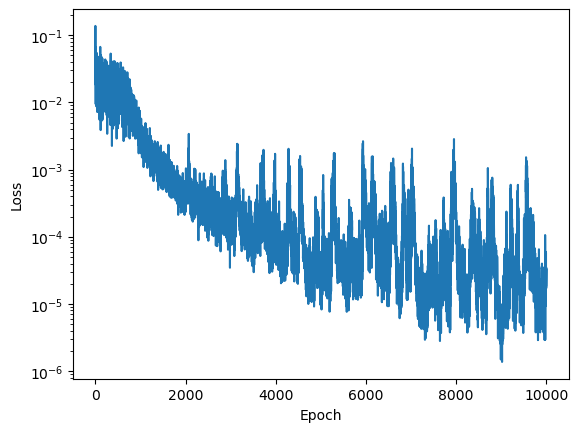

In [4]:
# Plot training
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel ('Loss')
plt.yscale('log')  # Set y-axis to log scale
plt.savefig('plots/training_loss.png')

NN MSE: 2.5139698672681024e-05
NN Norm: 0.08684416849624566
Upwind MSE: 0.002829888835125999
Upwind Norm: 0.9213938628717904
LW MSE: 0.00012262050253083968
LW Norm: 0.19179716045669684


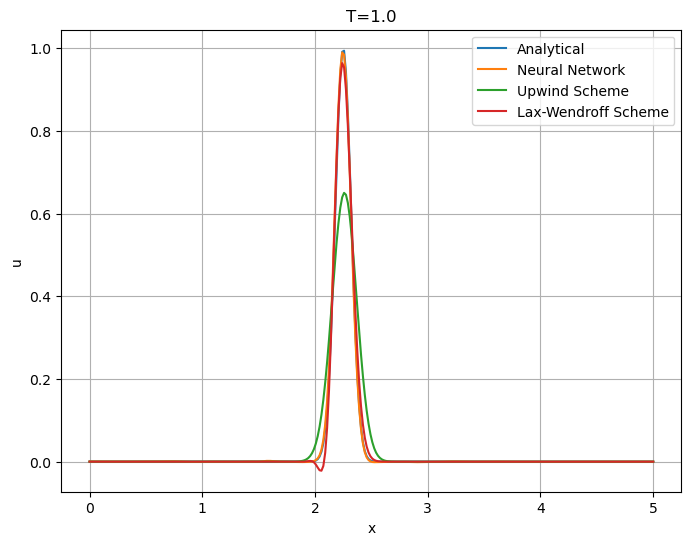

In [5]:
# Plot the results
plt.figure(figsize=(8, 6))

# Time Step
time = 1.0

################################################
# Analytical Solution

x_shifted = (x - a * time) % L  # Apply periodic boundary condition
u_analytical = np.exp(-((x_shifted - L/4) / 0.1) ** 2)
plt.plot(x, u_analytical, label="Analytical")


##############################################
# NN Solution
x_test = torch.tensor(x, dtype=torch.float32).reshape(-1, 1)

# Plot NN
t_test = torch.full_like(x_test,time) # Creates a vector with the same shape as x_test with a constant value equal to n
with torch.no_grad(): 
    u_nn = model(x_test, t_test).detach().numpy().flatten()  # Detach tensor before converting to NumPy
plt.plot(x, u_nn, label="Neural Network")

# Calculate errors
nn_diffs = u_analytical - u_nn
nn_mse = np.mean(np.square(nn_diffs))
nn_norm = np.linalg.norm(nn_diffs)
print("NN MSE: " + str(nn_mse))
print("NN Norm: " + str(nn_norm))

##############################################
# Upwind Scheme

u = initial_condition(x)  # Initialize solution

u_new = np.zeros_like(u)

for n in range(nt):
    # Apply Upwind update (first-order)
    u_new[1:] = u[1:] - c * (u[1:] - u[:-1])  # Forward in time, backward in space

    # Periodic boundary condition: Update the first point using the last point
    u_new[0] = u[0] - c * (u[0] - u[-1])

    # Update the field
    u[:] = u_new[:]

    # Plot at specific step and store
    if n == time*100:
        plt.plot(x, u, label="Upwind Scheme")

        # Calculate errors 
        upwind_diffs = u_analytical - u
        upwind_mse = np.mean(np.square(upwind_diffs))
        upwind_norm = np.linalg.norm(upwind_diffs)
        print("Upwind MSE: " + str(upwind_mse))
        print("Upwind Norm: " + str(upwind_norm))

################################################
# Lax-Wendroff

u = initial_condition(x)  # Initialize solution

# Lax-Wendroff Scheme
for n in range(nt):
    
    # Update solution
    u[1:-1] = (
        u[1:-1] 
        - (a * dt) / (2 * dx) * (u[2:] - u[:-2])  # First-order term
        + (a**2 * dt**2) / (2 * dx**2) * (u[2:] - 2 * u[1:-1] + u[:-2])  # Second-order term
    )
    
    # Periodic boundary conditions
    u[0] = u[-2]  # Update left boundary
    u[-1] = u[1]  # Update right boundary

    # Plot at specific step and record value
    if n == time*100:
        plt.plot(x, u, label=f"Lax-Wendroff Scheme")

        # Calculate errors
        lw_diffs = u_analytical - u
        lw_mse = np.mean(np.square(lw_diffs))
        lw_norm = np.linalg.norm(lw_diffs)
        print("LW MSE: " + str(lw_mse))
        print("LW Norm: " + str(lw_norm))
#################################################


# Set up plot
plt.legend()
plt.xlabel("x")
plt.ylabel("u")
plt.grid()
plt.title(f"T={time}")
plt.savefig(f'plots/comparison_{time}.png')
plt.show()